In [ ]:
from scipy import stats
from sklearn.metrics.pairwise import pairwise_distances
import numpy as np


class MeanShift:

    def __init__(self, bandwidth, max_iter, tol, metrics='euclidean'):
        self.bandwidth = bandwidth
        self.max_iter = max_iter
        self.tol = tol
        self.metrics = metrics
        self.bandwidth = bandwidth


    def __gaussian_kernel(self, x, y):
        return np.exp(-np.linalg.norm(x - y) ** 2 / (2 * (self.bandwidth ** 2)))


    def __reduce_centroids(self, centroids):
        self.centroids_labels = np.zeros(len(centroids), dtype=int)
        adjacency_matrix = pairwise_distances(X=centroids,
                                              metric=self.metrics)
        centroids_clusters = {}
        for i, row in enumerate(adjacency_matrix):
            in_core = False
            for values in centroids_clusters.values():
                if i in values:
                    in_core = True
                    break
            if not in_core:
                local_cores = np.where(row < self.bandwidth)[0]
                centroids_clusters[len(centroids_clusters)] = local_cores
        self.centroids = np.empty((len(centroids_clusters), len(centroids[0])))
        for i in centroids_clusters:
            self.centroids[i] = np.mean(centroids[centroids_clusters[i]],
                                        axis=0)
        adjacency_matrix = pairwise_distances(X=self.centroids, Y=self.X,
                                              metric=self.metrics)
        valid_centroids = []
        for i, row in enumerate(adjacency_matrix):
            neighbours = np.where(row < self.bandwidth)[0]
            if len(neighbours) > 1: #  иначе это скорее всего выброс
                valid_centroids.append(i)
        self.centroids = self.centroids[valid_centroids]


    def fit(self, X):
        self.X = X.copy()
        centroids = X.copy()
        average_weighted = np.empty((len(X), len(X[0])))
        for i in range(self.max_iter):
            adjacency_matrix = pairwise_distances(
                X=centroids, Y=X, metric=self.metrics)
            for j, centroid in enumerate(centroids):
                neighbours_id = np.where(adjacency_matrix[j] < self.bandwidth)[0]
                neighbours = X[neighbours_id]
                if len(neighbours) != 0:
                    density = np.array([self.__gaussian_kernel(centroid,
                        neighbour) for neighbour in neighbours])[:, np.newaxis]
                    average_weighted[j] = \
                        sum(density * neighbours) / sum(density)
                else:
                    average_weighted[j] = centroid.copy()
            if (np.abs(centroids - average_weighted) < self.tol).all():
                break
            centroids = average_weighted.copy()
        self.__reduce_centroids(centroids)


    def predict(self, X):
        self.labels = np.full(len(X), -1)
        np.random.shuffle(self.centroids)
        adjacency_matrix = pairwise_distances(
                X=self.centroids, Y=X, metric=self.metrics)
        shared_objects = {}
        for i, row in enumerate(adjacency_matrix):
            neighbours = np.where(row < self.bandwidth)[0]
            for neighbour in neighbours:
                if neighbour in shared_objects:
                    shared_objects[neighbour].append(i)
                else:
                    shared_objects[neighbour] = [i]
        for obj in shared_objects:
            dist_matrix = pairwise_distances(X=[X[obj]],
                                             Y=self.centroids[shared_objects[obj]],
                                             metric=self.metrics)
            min_id = np.argmin(dist_matrix)
            self.labels[obj] = shared_objects[obj][min_id]
        return self.labels

[ 2  2  2  1  0  0  1  1  2  1  1  1  2  0  1  1  1  0 -1  0  2  0  1  0
  0  0  1  1  0  0  2  2  1  1  2  2  0  0  0  0  2  2  1  0  0  2  2  0
  2  2  0  2  1  1  2  2  2  1  1  2  2  0  2  2  2  0  2  0  2  2  1  2
  2  0  0  0  0  2  2  1  0  2  2  2  2  2  1  1  2  2  0  1  1  0  1  1
  0  2  2  0  1  2  1  2  0  1  1  1  2  0  1  2  0  2  2  0  1  1  1  0
  1  1  2  2  1  2  0  0  1  2  0  0  2  1  2  2  0  1  1  2  0  0  1  2
  1  0  1  0  0  2  2  2  0  1  1  1  2  0  0  2  1  2  0  1  0  2  2  0
  2  0  1  2  1  0  0  2  2  2  0  0  2  2  0  1  2  0  0  1  0  2  2  2
  0  0  2  1  2  1  2  2  0  1  2  2  2  0  0  1  1  2  2  2  1  2  0  2
  1  2  0  1  2  0  2  1  2  1  1  1  2  1  1  0  1  2  2  0  1  1  0  1
  1  1  2  2  2  1  0  1  0  2  0  1  1  2  2  1  2 -1  0  1  0  2  2  0
  0  2  1  1  0  0  1  1  1  0  1  0  0  0  0 -1  0  0  2  2  2  1 -1  2
  0  0  0  0  1  1  1  1  2  0  2  0  1  1  1  0  2  1  0  0  2  0  2  2
  0  0  0  1  0  0  2  2  1  1  1  0  2  0  0  1  0

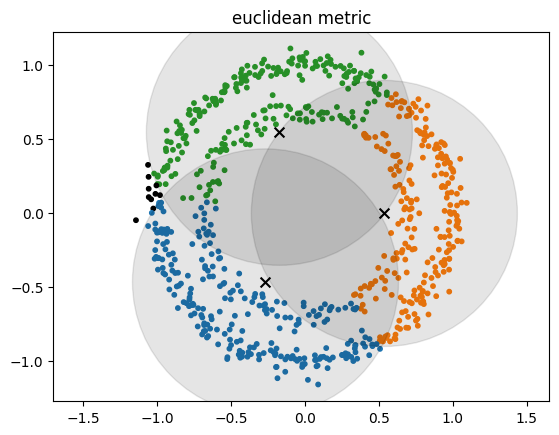

In [ ]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs, make_circles, make_moons


n_objects = [500, 250]
X, circle_labels = make_circles(n_samples=n_objects, noise=0.05, random_state=100,
                              factor=0.7)
bandwidth = 0.9
metrics='euclidean'
mean_shift = MeanShift(bandwidth=bandwidth, max_iter=50, tol=1e-2,
                       metrics=metrics)
mean_shift.fit(X)
labels = mean_shift.predict(X)
centroids = mean_shift.centroids

print(labels)
colors = ['black' if label == -1 else plt.cm.tab10(label) for label in labels] # шумы помечены чёрным цветом
plt.scatter(x=X[:, 0], y=X[:, 1], c=colors, s=10)
plt.scatter(x=centroids[:, 0], y=centroids[:, 1], marker='x', s=50,
            c='black', label='Centroids') # центроиды помечены чёрным цветом
if metrics == 'euclidean':
    for centroid in centroids:
        circle = plt.Circle(centroid, bandwidth, color='black', alpha=0.1)
        plt.gca().add_artist(circle)
plt.title(label=metrics + ' metric')
plt.axis('equal')
plt.show()

[ 4  4 -1 -1  4  4  4 -1 -1  4  4  4  4  4  4  4  4  4  4 -1 -1 -1  0 -1
 -1  4  4 -1  4  4 -1  4  4  4  4 -1 -1  4  4 -1  4  4  4  4 -1 -1 -1 -1
  0  4 -1  4  4  4  4 -1  4  4  4  4 -1 -1  4  0 -1  4 -1 -1  4  4  4 -1
  4  4 -1  4  4 -1  0  4 -1  0  4  4 -1  4  4  4  4  4 -1 -1  4 -1 -1 -1
  0  0 -1 -1  0 -1  4 -1  4  4  4  0  4  4  4  0  4  4  4  0 -1  4  4 -1
 -1 -1  4  4  4  4 -1 -1 -1 -1  4  4  4  4  4  4  4 -1 -1  4 -1  4  4  0
  4 -1  4  0  0 -1  4 -1  4  4  0 -1  4  4  4 -1 -1  4  4 -1  4  4 -1 -1
  4  4  4  4  4  4  4  4 -1 -1  4  4 -1  4  4  4  4 -1 -1  4 -1 -1  4 -1
  4  4 -1 -1  4  4  0 -1  4  4 -1 -1  4  4  4 -1 -1 -1  4  4  4  4  4  4
  4  4  4 -1  4 -1  4 -1  4  4  4 -1  4  4 -1 -1  4  4  4 -1 -1  4  4 -1
  4  4  4  4 -1 -1 -1 -1 -1  4 -1  4  4 -1 -1 -1  4  4  4  4 -1  4  4 -1
 -1  4 -1 -1  4  4 -1 -1  4  4 -1  4  4 -1 -1  4  4 -1  4  4 -1  4  4  4
  4  4 -1 -1  4 -1  4 -1 -1 -1 -1  4 -1 -1  4 -1 -1  4  4 -1  4 -1  4 -1
  4  4  4 -1 -1  4  4 -1 -1 -1  4  4  4  4 -1  4 -1

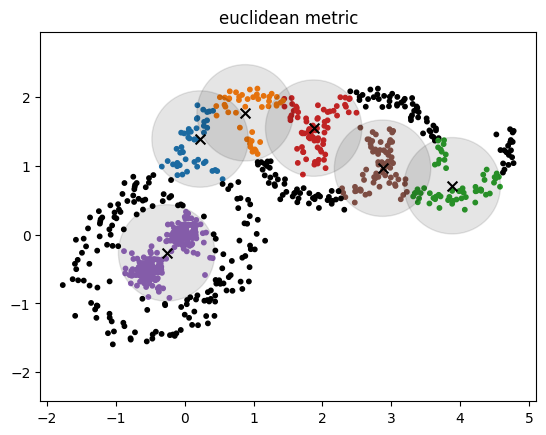

In [ ]:
n_objects = [100, 100]
X, circle_labels = make_circles(n_samples=n_objects, noise=0.1, random_state=100,
                              factor=0.1)
X_2 = X - 0.5
X_3, moon_labels = make_moons(n_samples=n_objects, noise=0.075, random_state=0)
X_3 += 1
X_4 = X_3.copy()
X_4[:, 0] = X_4[:, 0] + 1.75
X = np.concatenate((X, X_2), axis=0)
X = np.concatenate((X, X_3), axis=0)
X = np.concatenate((X, X_4), axis=0)

metrics = 'euclidean'
bandwidth = 0.7
mean_shift = MeanShift(bandwidth=bandwidth, max_iter=100,
                       tol=1e-2, metrics=metrics)
mean_shift.fit(X)
labels = mean_shift.predict(X)
centroids = mean_shift.centroids

print(labels)
colors = ['black' if label == -1 else plt.cm.tab10(label) for label in labels] # шумы помечены чёрным цветом
plt.scatter(x=X[:, 0], y=X[:, 1], c=colors, s=10)
plt.scatter(x=centroids[:, 0], y=centroids[:, 1], marker='x', s=50,
            c='black', label='Centroids') # центроиды помечены чёрным цветом
if metrics == 'euclidean':
    for centroid in centroids:
        circle = plt.Circle(centroid, bandwidth, color='black', alpha=0.1)
        plt.gca().add_artist(circle)
plt.title(label=metrics + ' metric')
plt.axis('equal')
plt.show()

[ 2  5  1  6  4  8  5  0  1  6  1  0  6 -1  2  7  8  5  2  4  2  1  2  7
  3  5  5  8  8  1  6  4  1  2  5  0  1  8  1  0  1 -1 -1  1  8  4  6  8
 -1  1  0 -1  5  8  7  0  3  3  5  7  4  7  6  1  8  0  7 -1 -1  3  2  5
  1  6  3  6  5  1  7  1  3 -1 -1  3  8  6  1  1  2 -1  2  8  5  2  5  0
  7  1  1 -1  6  8  8  8  4  8  7  1  1  3  0  5  4  0  7  8  2  2  6  4
  2  6  1  3  6  4 -1  8  2  2  1 -1  6  8  7  6  2  4  6  4  8  3  8  2
  2  0 -1  0 -1  6  8  5  2 -1 -1  8  7  0  4  0  1  7  6  3  1  2  6  0
  7 -1 -1  4  5  1  1  4  8  5  6  3  7  3  5 -1  1  1  8  1  5  4 -1  7
  5 -1 -1 -1  7  3  2  1  0 -1 -1  7  2  0  0 -1  1 -1  6  4  5  7  4  1
 -1  2  2  7  0 -1  1  7 -1  3  7  8  1 -1 -1  0  3  1  1  0  1  3  1  6
  3  5  6  1  1  4  0  6  4  1  1  5 -1  1  4  7 -1  0 -1  7  7  5 -1  3
  7 -1  7  6  0  2  5  1  1  2  6  1 -1 -1  5  0  0 -1  2 -1 -1  4  6  6
  1  2  8  3  4  4  0  3  0  7 -1  4]


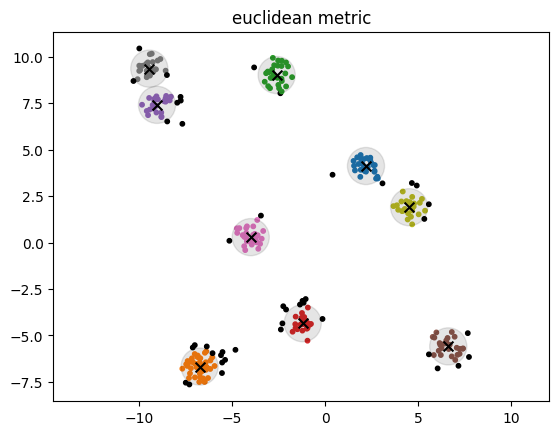

In [ ]:
n_objects = 300
X, blob_labels = make_blobs(n_samples=n_objects , centers=10, cluster_std=0.50, random_state=42)

metrics = 'euclidean'
bandwidth = 1
mean_shift = MeanShift(bandwidth=bandwidth, max_iter=100, tol=1e-2,
                       metrics=metrics)
mean_shift.fit(X)
labels = mean_shift.predict(X)
centroids = mean_shift.centroids

print(labels)
colors = ['black' if label == -1 else plt.cm.tab10(label) for label in labels] # шумы помечены чёрным цветом
plt.scatter(x=X[:, 0], y=X[:, 1], c=colors, s=10)
plt.scatter(x=centroids[:, 0], y=centroids[:, 1], marker='x', s=50,
            c='black', label='Centroids') # центроиды помечены чёрным цветом
if metrics == 'euclidean':
    for centroid in centroids:
        circle = plt.Circle(centroid, bandwidth, color='black', alpha=0.1)
        plt.gca().add_artist(circle)
plt.title(label=metrics + ' metric')
plt.axis('equal')
plt.show()